In [2]:
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

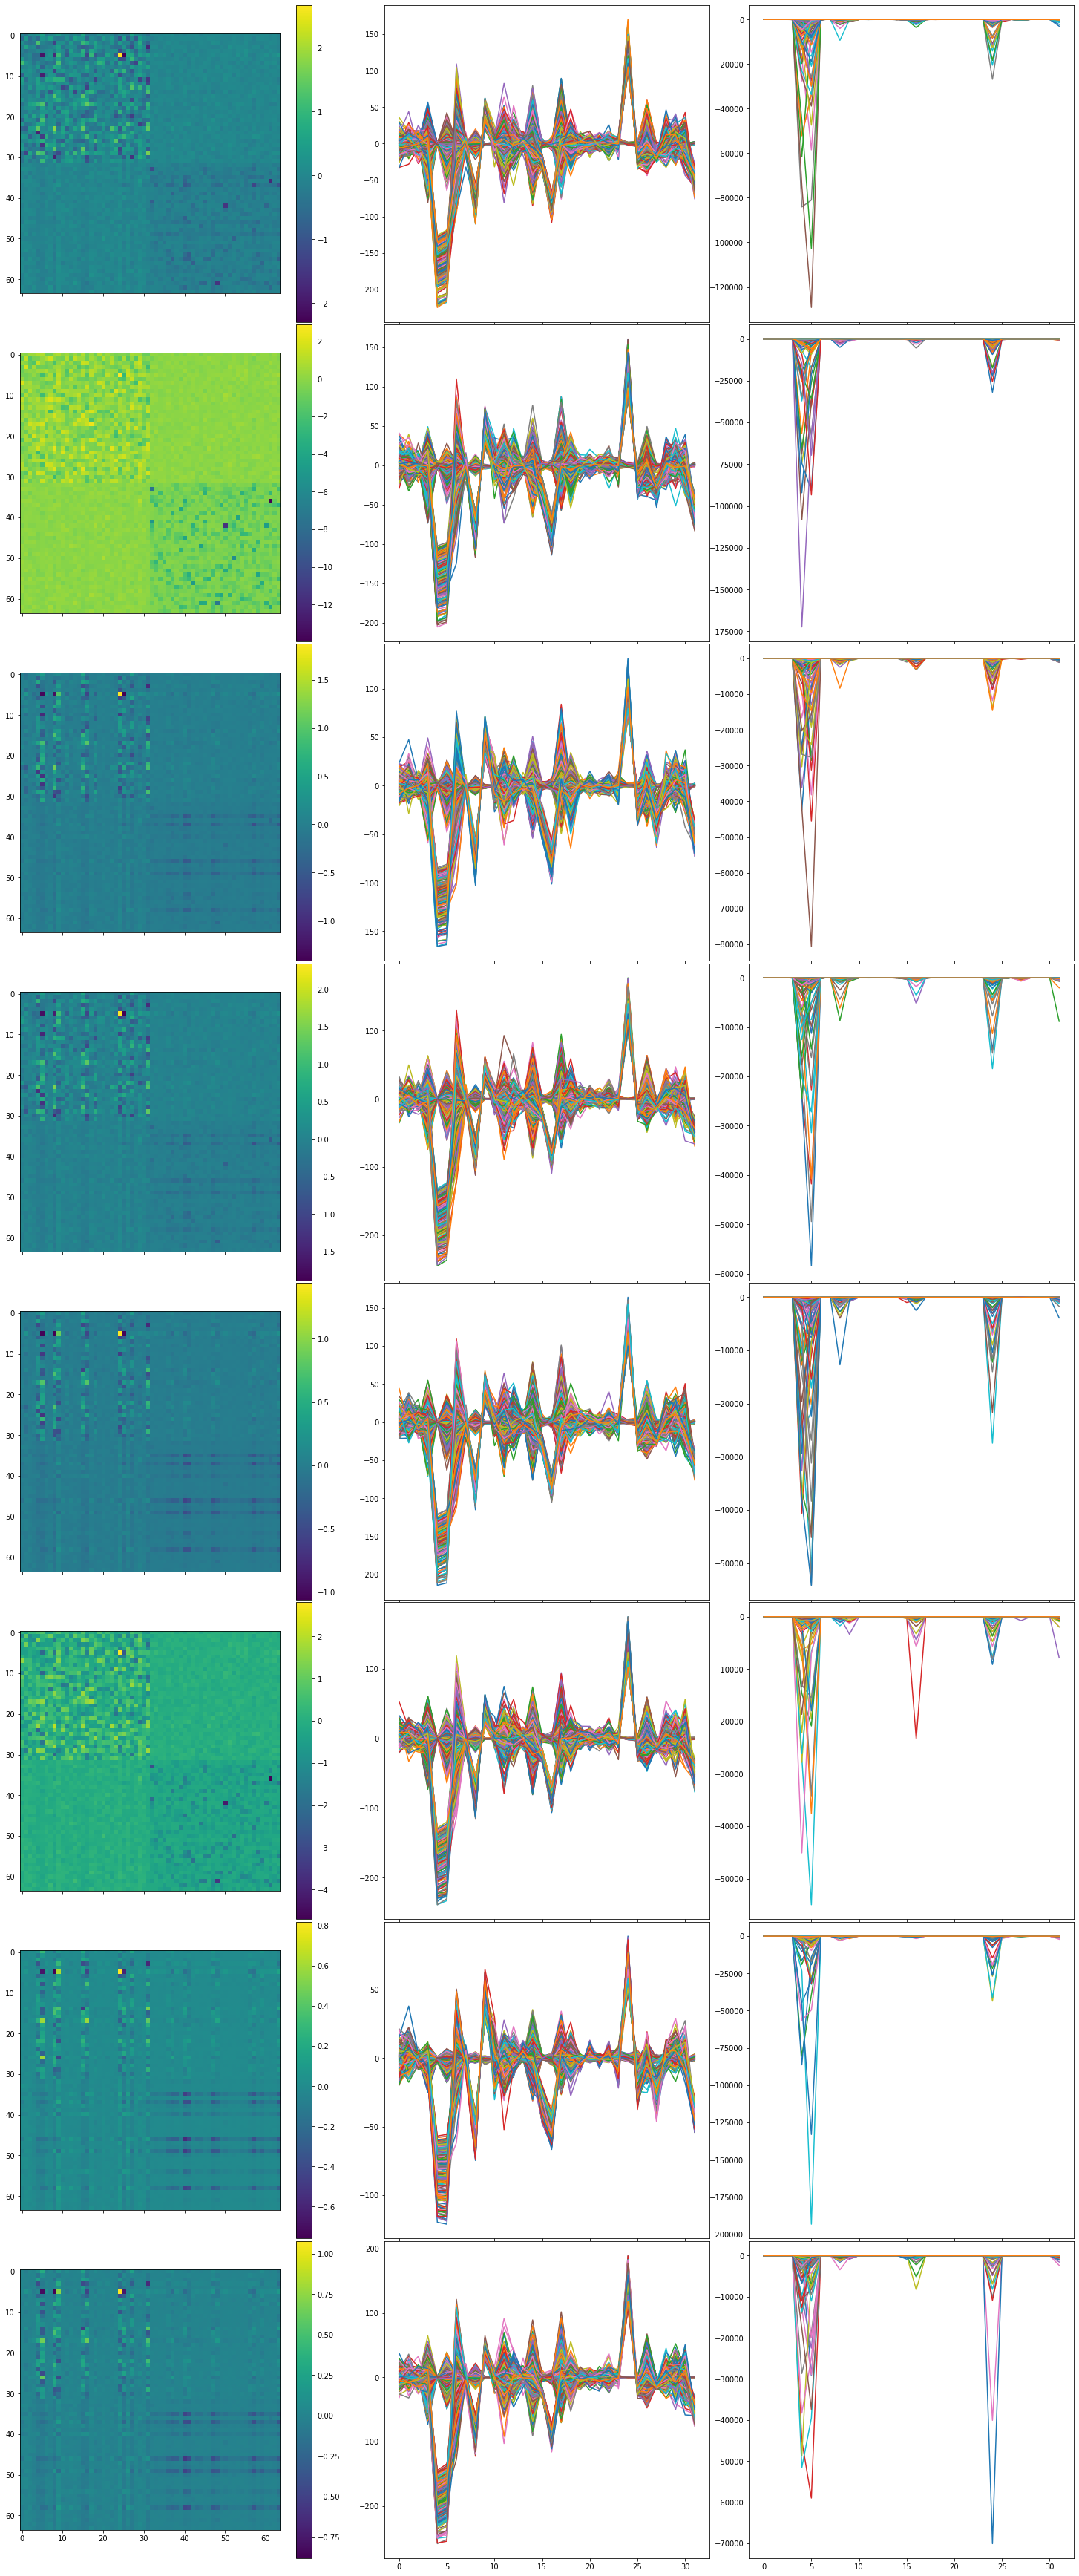

In [19]:
G_paths = glob.glob('runs/MNIST_SVHN/test/G*pt')
nu1_paths = glob.glob('runs/MNIST_SVHN/test/nu1*pt')
nu2_paths = glob.glob('runs/MNIST_SVHN/test/nu2*pt')
fig, ax = plt.subplots(ncols=3, nrows=len(G_paths), figsize=(20, len(G_paths)*6), sharex='col')

for i, path in enumerate(zip(G_paths, nu1_paths, nu2_paths)):
    G = torch.load(path[0]).detach().cpu().numpy()#.clip(min=-100, max=100)
    im = ax[i, 0].imshow(G)
    fig.colorbar(im, ax=ax[i, 0])
    # ax[i, 0].set_axis_off()
    
    nu1 = torch.load(path[1])
    ax[i, 1].plot(nu1[0].detach().cpu().numpy().T)
    ax[i, 1].plot(nu1[1].detach().cpu().numpy().T)
    nu2 = torch.load(path[2])
    ax[i, 2].plot(nu2[0].detach().cpu().numpy().T)
    ax[i, 2].plot(nu2[1].detach().cpu().numpy().T)
fig.tight_layout(pad=0)

In [34]:
def value_calc(z, G, nu1, nu2):
    T = torch.cat((z, torch.square(z)), 1)
    Tp = torch.matmul(T, G)
    mid = G.shape[1] // 2

    if nu2 is not None:
        var = -torch.reciprocal(2 * (-1 + nu2 + Tp[:, mid:]))
    else:
        var = -torch.reciprocal(2 * (-1 + Tp[:, mid:]))
        
    if nu1 is not None:
        mean = var * (Tp[:, :mid] + nu1)
    else:
        mean = var * Tp[:, :mid]
    
    return mean, var

def calc_cond_mean_var(G, nu1, nu2, n_iterations=30):
    mean, var = [[], []], [[], []]
    z = [[torch.randn(nu1[0].shape).cuda()], [torch.randn(nu1[1].shape).cuda()]]
    
    for i in range(n_iterations):
        ret = value_calc(z[1][-1], G.t(), nu1[0], nu2[0])
        z_new = ret[0] + torch.sqrt(ret[1]) * torch.randn_like(ret[1])
        z[0].append(z_new)
        mean[0].append(ret[0])
        var[0].append(ret[1])
        
        ret = value_calc(z[0][-1], G, nu1[1], nu2[1])
        z_new = ret[0] + torch.sqrt(ret[1]) * torch.randn_like(ret[1])
        z[1].append(z_new)
        mean[1].append(ret[0])
        var[1].append(ret[1])
    return z, mean, var

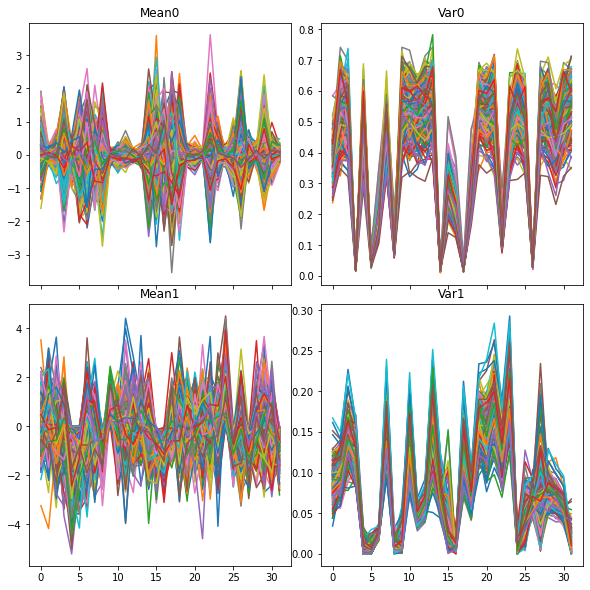

In [48]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharex='col')

G = torch.load('runs/MNIST_SVHN/test/G_40.pt')
nu1 = torch.load('runs/MNIST_SVHN/test/nu1_40.pt') # List
nu2 = torch.load('runs/MNIST_SVHN/test/nu2_40.pt') # List

z, mean, var = calc_cond_mean_var(G, nu1, nu2, 2000)

for i in (0, 1):
    ax[i, 0].plot(mean[i][-1].detach().cpu().numpy().T)
    ax[i, 1].plot(var[i][-1].detach().cpu().numpy().T)
    ax[i, 0].set_title('Mean%d' % i)
    ax[i, 1].set_title('Var%d' % i)
    
fig.tight_layout(pad=0)

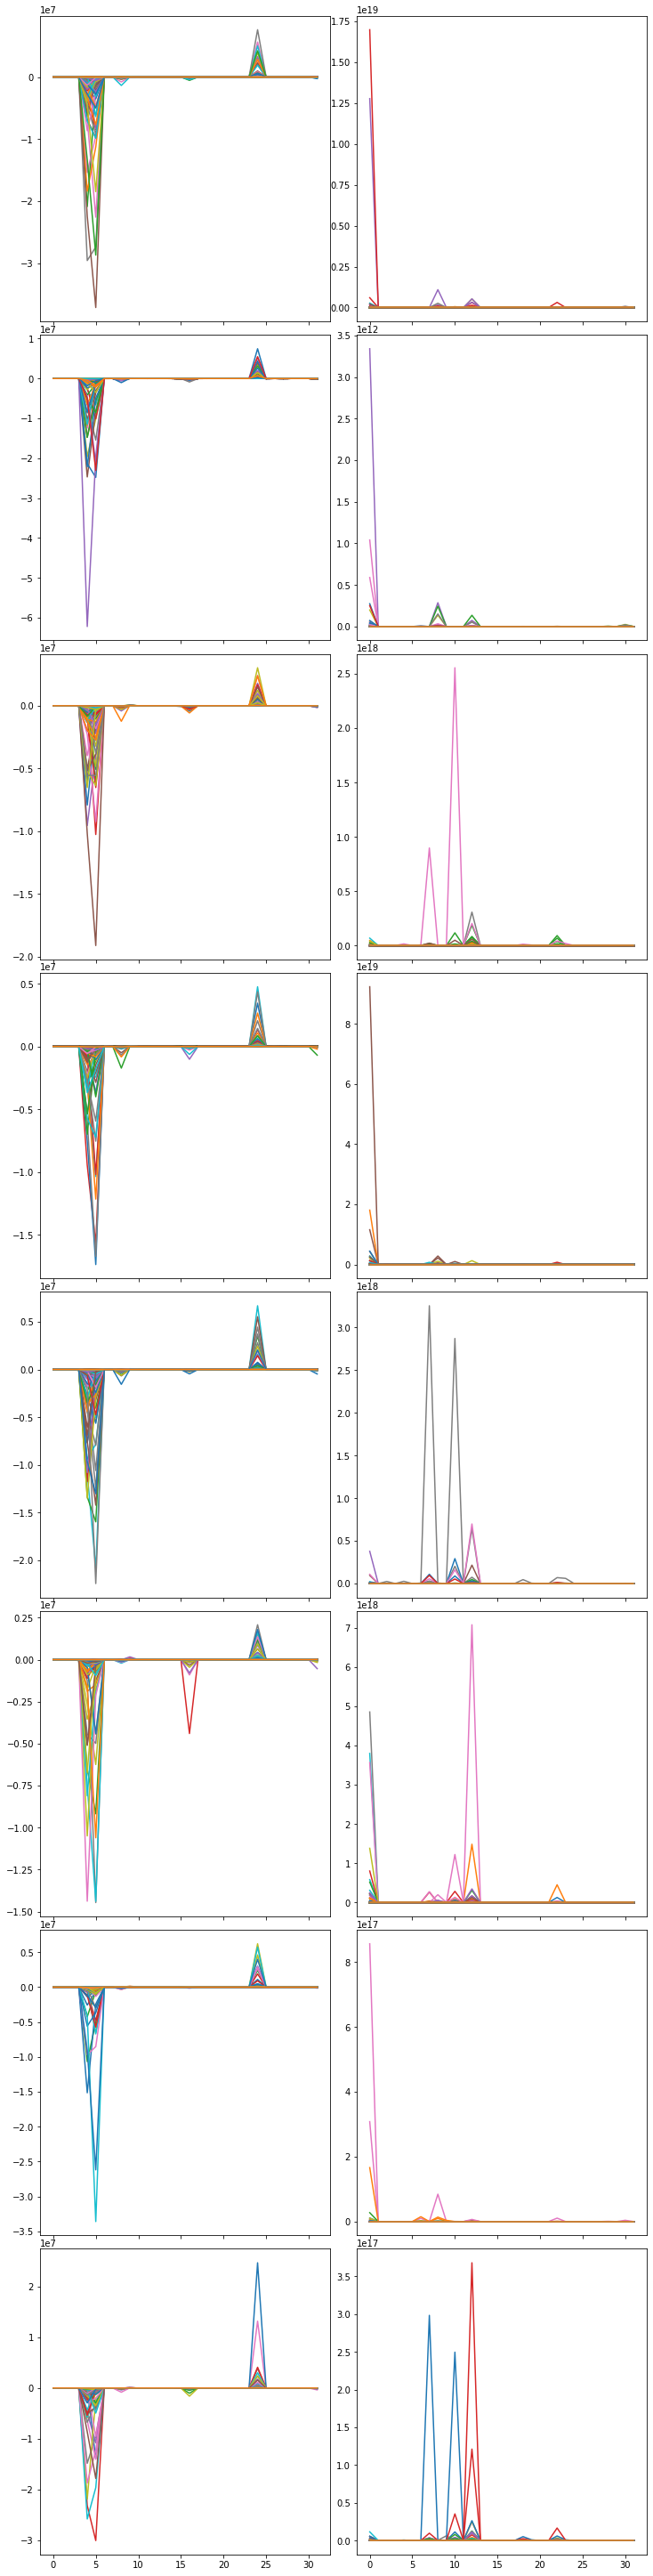

In [56]:
G_paths = glob.glob('runs/MNIST_SVHN/test/G*pt')
nu1_paths = glob.glob('runs/MNIST_SVHN/test/nu1*pt')
nu2_paths = glob.glob('runs/MNIST_SVHN/test/nu2*pt')
fig, ax = plt.subplots(ncols=2, nrows=len(G_paths), figsize=(10, len(G_paths)*5), sharex='col')

for i, path in enumerate(zip(nu1_paths, nu2_paths)):
    nu1 = torch.load(path[0])
    nu2 = torch.load(path[1])
    
    var = [-1/(2 * nu2[0]), -1/(2 * nu2[1])]
    mean = [nu1[0] / var[0], nu1[1] / var[1]]
    
    ax[i, 0].plot(mean[0].detach().cpu().numpy().T)
    ax[i, 0].plot(mean[1].detach().cpu().numpy().T)
    ax[i, 1].plot(var[0].detach().cpu().numpy().T)
    ax[i, 1].plot(var[1].detach().cpu().numpy().T)
fig.tight_layout(pad=0)